# Download UrbanSound8K Dataset from Kaggle using Opendatasets

In [ ]:
from google.colab import files

print(f"{'*'*27}\n* Upload Kaggle.json file *\n{'*'*27}")
kaggle_json = files.upload()

***************************
* Upload Kaggle.json file *
***************************


Saving kaggle.json to kaggle.json


In [ ]:
%%capture
!pip install opendatasets

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/chrisfilo/urbansound8k'
od.download(dataset_url)

100%|██████████| 5.61G/5.61G [01:01<00:00, 97.6MB/s]


# Import Necessary Libraries

In [ ]:
%%capture
!pip install librosa

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import librosa
import librosa.display
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

# EDA

In [ ]:
all_audio_files = glob.glob("/content/urbansound8k/*/*.wav")
print(f"Total Audio Files: {len(all_audio_files)}")
print(f"Sampel file: {all_audio_files[0]}")

Total Audio Files: 8732
Sampel file: /content/urbansound8k/fold8/55013-3-0-1.wav


In [ ]:
filename = all_audio_files[0]
data, sample_rate=librosa.load(filename)
print(f"data shape: {data.shape}\ndata sample: {data[:3]}...")
print(f"sample rate: {sample_rate}")
ipd.Audio(filename)

data shape: (88200,)
data sample: [0.00230569 0.00319139 0.00233925]...
sample rate: 22050


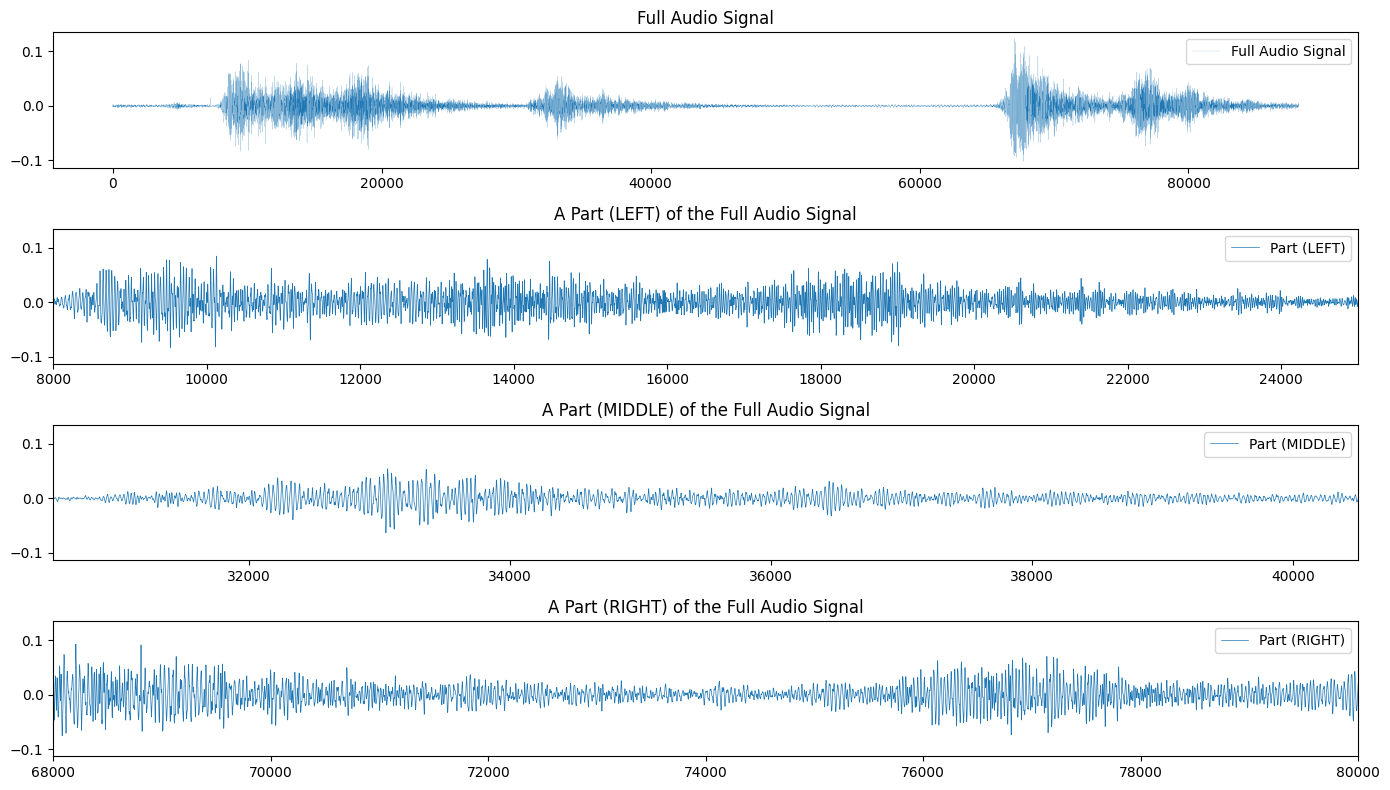

In [ ]:
# Plot the first subplot
plt.subplot(4, 1, 1)
pd.Series(data).plot(figsize=(14,8), lw=0.1, label='Full Audio Signal')
plt.title('Full Audio Signal')
plt.legend()

# Plot the second subplot
plt.subplot(4, 1, 2)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (LEFT)')
plt.xlim(8000, 25000)
plt.title('A Part (LEFT) of the Full Audio Signal')
plt.legend()

# Plot the third subplot
plt.subplot(4, 1, 3)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (MIDDLE)')
plt.xlim(30500, 40500)
plt.title('A Part (MIDDLE) of the Full Audio Signal')
plt.legend()

# Plot the fourth subplot
plt.subplot(4, 1, 4)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (RIGHT)')
plt.xlim(68000, 80000)
plt.title('A Part (RIGHT) of the Full Audio Signal')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined figure
plt.show()

In [ ]:
metadata = pd.read_csv('/content/urbansound8k/UrbanSound8K.csv')
metadata.sample(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
7232,65745-3-0-49.wav,65745,24.500000,28.500000,2,7,3,dog_bark
7283,66622-4-0-2.wav,66622,1.000000,5.000000,1,3,4,drilling
4827,191382-3-0-0.wav,191382,0.618580,4.618580,1,5,3,dog_bark
6409,42117-8-0-0.wav,42117,88.660252,92.660252,2,3,8,siren
3019,164053-8-1-0.wav,164053,13.783876,17.783876,2,1,8,siren


In [ ]:
file_paths = []
for idx in tqdm(range(len(metadata))):
    # "/content/urbansound8k/fold" + str(fold) + "/" + slice_file_name
    slice_file_name = metadata.iloc[idx, 0]
    fold = metadata.iloc[idx, 5]
    full_path = "/content/urbansound8k/fold" + str(fold) + "/" + slice_file_name
    file_paths.append(full_path)

metadata['full_path'] = file_paths
metadata.sample(5)

100%|██████████| 8732/8732 [00:00<00:00, 18960.04it/s]


,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path
1925,146845-0-0-18.wav,146845,9.000000,13.000000,1,7,0,air_conditioner,/content/urbansound8k/fold7/146845-0-0-18.wav
5130,199261-3-0-0.wav,199261,0.211116,4.211116,1,10,3,dog_bark,/content/urbansound8k/fold10/199261-3-0-0.wav
8380,90013-7-0-4.wav,90013,34.852372,38.852372,1,5,7,jackhammer,/content/urbansound8k/fold5/90013-7-0-4.wav
3531,172338-9-0-21.wav,172338,98.760480,102.760480,1,4,9,street_music,/content/urbansound8k/fold4/172338-9-0-21.wav
7616,73168-1-0-0.wav,73168,0.067329,0.724461,1,9,1,car_horn,/content/urbansound8k/fold9/73168-1-0-0.wav


In [ ]:
# play the audio of a random file
_idx = random.randint(0, len(metadata))
filename = metadata.iloc[_idx, -1]
data, sample_rate=librosa.load(filename)
print(f"data shape: {data.shape}\ndata sample: {data[:3]}...")
print(f"sample rate: {sample_rate}")
print(f"class: {metadata.iloc[_idx, -2]}")
ipd.Audio(filename)

data shape: (88200,)
data sample: [-0.00879964 -0.01114841 -0.00804064]...
sample rate: 22050
class: children_playing


In [ ]:
### Check whether the dataset is imbalanced
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

# Feature Extraction Using MFCC

In [ ]:
def feature_extractor(file):
    raw_audio, sample_rate = librosa.load(file)
    # raw_audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=raw_audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [ ]:
metadata['mfcc_feature'] = metadata['full_path'].apply(feature_extractor)
metadata.sample(5)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path,mfcc_feature
1782,145206-6-0-0.wav,145206,0.099885,1.340558,1,8,6,gun_shot,/content/urbansound8k/fold8/145206-6-0-0.wav,"[-194.57439, 88.66908, -8.544744, 28.435852, 1..."
1893,146714-0-0-13.wav,146714,6.500000,10.500000,2,3,0,air_conditioner,/content/urbansound8k/fold3/146714-0-0-13.wav,"[-298.2934, 59.61371, 50.071995, 5.981914, 10...."
7196,63261-3-0-1.wav,63261,0.500000,4.500000,1,2,3,dog_bark,/content/urbansound8k/fold2/63261-3-0-1.wav,"[-311.07697, 128.94872, -57.112926, -64.319496..."
8172,81117-4-0-4.wav,81117,2.705940,6.705940,1,9,4,drilling,/content/urbansound8k/fold9/81117-4-0-4.wav,"[-36.791393, -18.375013, -32.769684, -20.49527..."
6944,58937-4-0-2.wav,58937,2.200341,6.200341,1,9,4,drilling,/content/urbansound8k/fold9/58937-4-0-2.wav,"[-75.936226, 87.46117, 10.07438, 11.792025, -2..."


In [ ]:
extracted_features = metadata.iloc[:, [-1, -3]]
extracted_features

,mfcc_feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.816488, ...",car_horn
8730,"[-336.92386, 115.3139, -44.84709, 24.968985, -...",car_horn


In [ ]:
X = np.array(extracted_features['mfcc_feature'].tolist())
y = np.array(extracted_features['class'].tolist())

X.shape, y.shape

((8732, 40), (8732,))

In [ ]:
y = np.array(pd.get_dummies(y))
y.shape

(8732, 10)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6985, 40), (1747, 40), (6985, 10), (1747, 10))

# SVM, LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, GaussianNB

In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [ ]:
# Create an SVM classifier
svm_classifier = svm.SVC()

# Fit the classifier on the training data
svm_classifier.fit(X_train, y_train.argmax(axis=1))

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)  # Assuming y_test is one-hot encoded

# Print the accuracy
print(f"SVM Accuracy: {accuracy}")

SVM Accuracy: 0.6050372066399542


In [ ]:
# Logistic Regression
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train.argmax(axis=1))
logreg_pred = logreg_classifier.predict(X_test)
logreg_accuracy = accuracy_score(y_test.argmax(axis=1), logreg_pred)
print(f"Logistic Regression Accuracy: {logreg_accuracy}")

Logistic Regression Accuracy: 0.5449341728677733


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# K-Nearest Neighbors
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train.argmax(axis=1))
knn_pred = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test.argmax(axis=1), knn_pred)
print(f"K-Nearest Neighbors Accuracy: {knn_accuracy}")

K-Nearest Neighbors Accuracy: 0.8311390955924441


In [ ]:
# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train.argmax(axis=1))
dt_pred = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test.argmax(axis=1), dt_pred)
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 0.7057813394390383


In [ ]:
# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train.argmax(axis=1))
rf_pred = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test.argmax(axis=1), rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.8820835718374356


In [ ]:
# Naive Bayes
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train.argmax(axis=1))
nb_pred = nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test.argmax(axis=1), nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy}")

Naive Bayes Accuracy: 0.4813966800228964


# Comparing Empirical Outcomes of Different ML Methods

In [ ]:
pd.DataFrame({
    'Classifier': ['SVC', 'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GaussianNB'],
    'Accuracy': [0.605, 0.545, 0.831, 0.706, 0.882, 0.481]
})

,Classifier,Accuracy
0,SVC,0.605
1,LogisticRegression,0.545
2,KNeighborsClassifier,0.831
3,DecisionTreeClassifier,0.706
4,RandomForestClassifier,0.882
5,GaussianNB,0.481


from matplotlib import pyplot as plt
_df_0['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Classifier').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Classifier'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Accuracy', y='Classifier', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)